References:
```
# https://www.kaggle.com/code/dipitj/resnet152v2-valacc-89-5
```
```
# https://www.analyticsvidhya.com/blog/2021/05/plant-seedlings-classification-using-cnn-with-python-code/
```
```
# https://github.com/professionalhima/UTAustin_PGP_Projects/blob/main/Plant%20Seedlings%20Image%20Classification%20using%20CNNs%20in%20Keras/Project_7_PlantSeedlingCNN_Himaja_Sol_v1.ipynb
```







In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
pip install tensorflow

In [ ]:
import opendatasets as od
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, model_from_json, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import preprocessing
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly.graph_objs as go
import pandas as pd
import random
import shutil
from prettytable import PrettyTable
from math import sqrt, floor
from tqdm import tqdm

import os
import cv2

import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf

import PIL
import plotly


In [ ]:
od.download("https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shashwat16shekhar
Your Kaggle Key: ··········


100%|██████████| 3.19G/3.19G [00:49<00:00, 69.9MB/s]


In [ ]:
image_dir = pathlib.Path("/content/v2-plant-seedlings-dataset")

image_list = list(image_dir.glob(r"**/*.png"))
exclude_dirs = [
    "/content/v2-plant-seedlings-dataset/nonsegmentedv2",
    "/content/v2-plant-seedlings-dataset/test",
    "/content/v2-plant-seedlings-dataset/train",
    "/content/v2-plant-seedlings-dataset/validation",
]

image_list = [path for path in image_list if not any(exclude_dir in str(path) for exclude_dir in exclude_dirs)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_list))
image_df = pd.DataFrame({'FilePath': image_list, 'Labels': labels}).astype(str).sample(frac=1.0, random_state=1)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=2)

print(train_df.shape, test_df.shape)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

img_rows, img_cols = 224, 224
batch_size = 32
classes = train_df['Labels'].nunique()

print("Number of classes:", classes)


(3877, 2) (1662, 2)
Number of classes: 12


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "FilePath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    subset = "training",
    shuffle = True,
    class_mode = "categorical"
)

Found 3102 validated image filenames belonging to 12 classes.


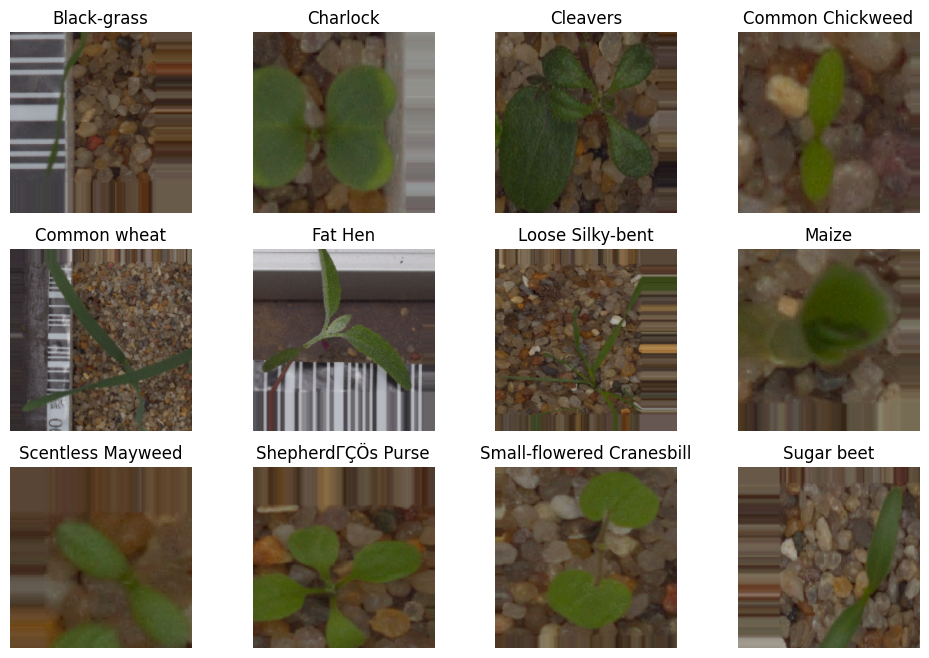

In [ ]:

def display_images(generator, num_rows=3, num_cols=4):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(12, 8))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)

        # Find an image with the current class
        image_idx = np.argmax(labels[:, i])
        plt.imshow(images[image_idx])

        plt.title(class_names[i])
        plt.axis('off')
    plt.show()

display_images(train_generator, num_rows=3, num_cols=4)


In [ ]:
val_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "FilePath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    subset = "validation",
    shuffle = False,
    class_mode = "categorical"
)

Found 775 validated image filenames belonging to 12 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "FilePath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    shuffle = False,
    class_mode = "categorical"
)

Found 1662 validated image filenames belonging to 12 classes.


In [ ]:
basemodel = tf.keras.applications.ResNet152V2(
    weights="imagenet",
    input_shape=(img_rows, img_cols, 3),
    include_top=False
)

for layer in basemodel.layers:
    layer.trainable = False

x = basemodel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

output = tf.keras.layers.Dense(classes, activation="softmax")(x)

model = tf.keras.Model(inputs=basemodel.inputs, outputs=output)

model.summary()


234545216/234545216 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = val_generator
)

Epoch 1/20
97/97 [==============================] - 115s 955ms/step - loss: 2.1106 - accuracy: 0.2956 - val_loss: 1.4529 - val_accuracy: 0.5097
Epoch 2/20
97/97 [==============================] - 82s 845ms/step - loss: 1.5007 - accuracy: 0.4787 - val_loss: 1.1211 - val_accuracy: 0.6129
Epoch 3/20
97/97 [==============================] - 81s 841ms/step - loss: 1.2677 - accuracy: 0.5509 - val_loss: 0.9806 - val_accuracy: 0.6323
Epoch 4/20
97/97 [==============================] - 81s 836ms/step - loss: 1.1467 - accuracy: 0.5935 - val_loss: 0.8127 - val_accuracy: 0.7084
Epoch 5/20
97/97 [==============================] - 84s 872ms/step - loss: 1.0543 - accuracy: 0.6302 - val_loss: 0.8129 - val_accuracy: 0.7226
Epoch 6/20
97/97 [==============================] - 81s 835ms/step - loss: 0.9590 - accuracy: 0.6628 - val_loss: 0.7615 - val_accuracy: 0.7445
Epoch 7/20
97/97 [==============================] - 79s 818ms/step - loss: 0.9293 - accuracy: 0.6863 - val_loss: 0.6372 - val_accuracy: 0.792

In [ ]:
scores = model.evaluate(val_generator, verbose = 1)
print("Loss: {:.3f}".format(scores[0]))
print("Accuracy: {:.3f}".format(scores[1]))

25/25 [==============================] - 20s 786ms/step - loss: 0.5721 - accuracy: 0.8116
Loss: 0.572
Accuracy: 0.812


In [ ]:
test_pred = model.predict(test_generator, verbose=1)
test_labels = np.argmax(test_pred, axis=1)
test_labels[:10]

52/52 [==============================] - 23s 348ms/step


array([ 7,  6, 11,  6,  3,  5,  5,  3,  5,  1])

1/1 [==============================] - 0s 76ms/step


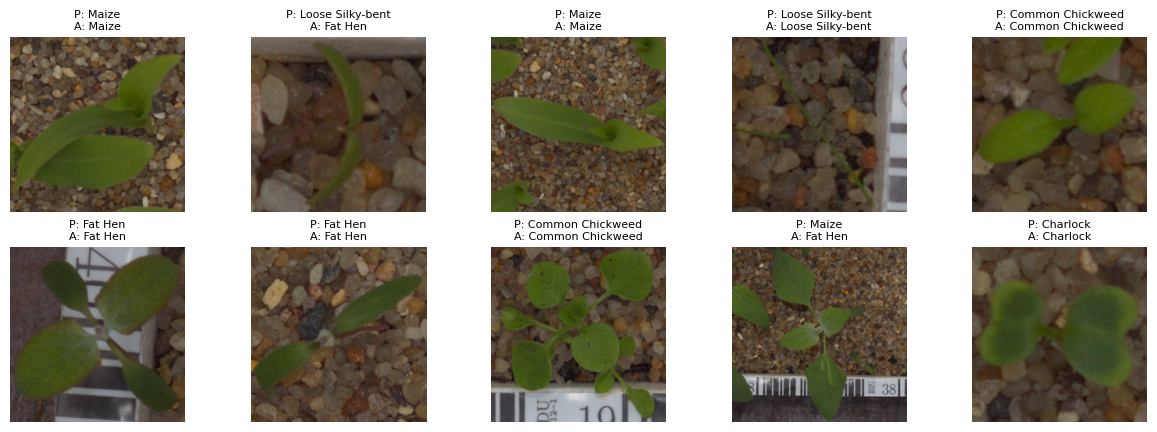

In [ ]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

num_images = 10

sample_images = [load_and_preprocess_image(image_path) for image_path in test_generator.filepaths[:num_images]]
sample_images = np.array(sample_images)

sample_predictions = model.predict(sample_images, verbose=1)
sample_labels = np.argmax(sample_predictions, axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f'P: {classes[sample_labels[i]]}\nA: {classes[test_labels[i]]}', fontsize=8)
    plt.axis('off')

plt.show()

In [ ]:
predictions = model.predict(test_generator)
test_labels = test_generator.classes

class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
classes = list(class_labels.values())

print("Classes:")
for class_name in classes:
    print(class_name)

print("\nClassification Report")
print(classification_report(test_labels, np.argmax(predictions, axis=1), target_names=classes))



52/52 [==============================] - 25s 472ms/step
Classes:
Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
ShepherdΓÇÖs Purse
Small-flowered Cranesbill
Sugar beet

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.55      0.19      0.28        94
                 Charlock       0.85      0.97      0.90       130
                 Cleavers       0.93      0.77      0.84       102
         Common Chickweed       0.88      0.94      0.91       212
             Common wheat       0.85      0.79      0.82        78
                  Fat Hen       0.78      0.90      0.84       173
         Loose Silky-bent       0.70      0.95      0.80       230
                    Maize       0.94      0.88      0.91        76
        Scentless Mayweed       0.91      0.82      0.86       174
       ShepherdΓÇÖs Purse       0.81      0.57      0.67        80
Small-flo

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

print("Test Accuracy:", accuracy_score(test_labels, predicted_labels))
print("Precision:", precision_score(test_labels, predicted_labels, average='weighted'))
print("Recall:", recall_score(test_labels, predicted_labels, average='weighted'))
print("F1 Score:", f1_score(test_labels, predicted_labels, average='weighted'))


Test Accuracy: 0.8369434416365824
Precision: 0.836602154232865
Recall: 0.8369434416365824
F1 Score: 0.8258922784013644


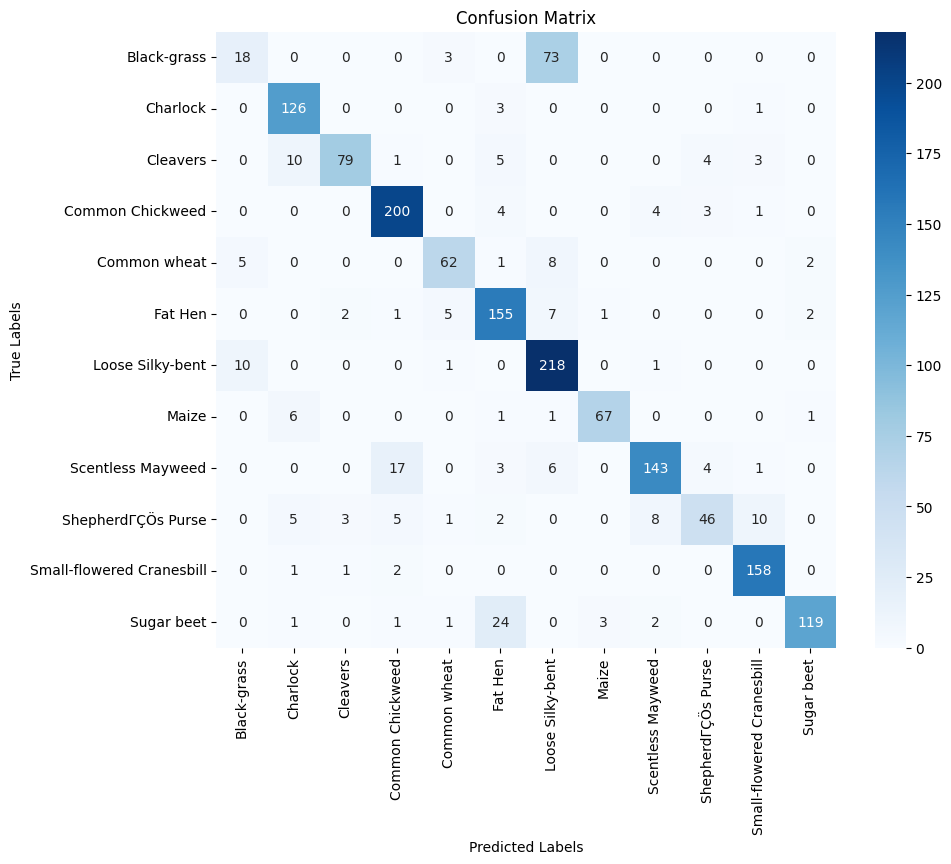

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

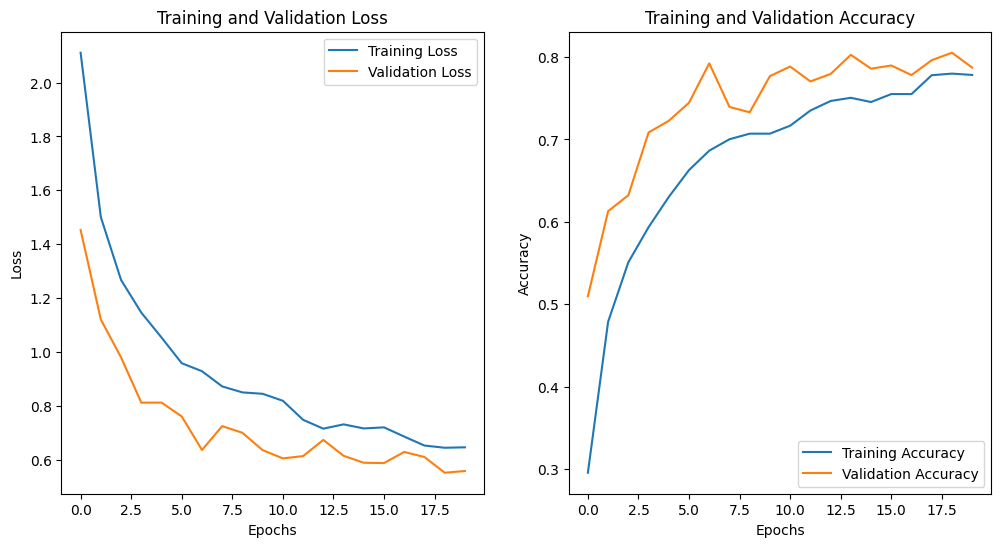

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

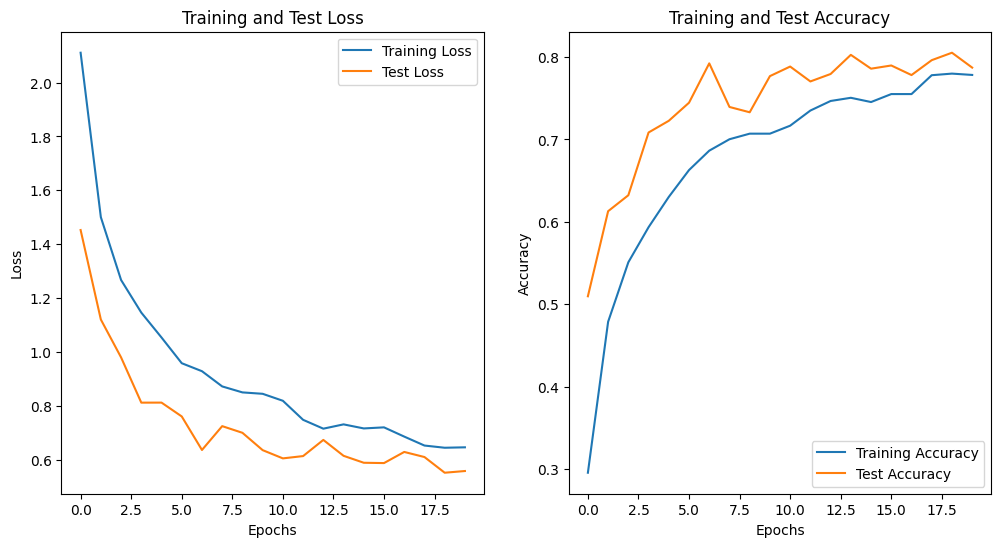

In [ ]:
# Plot training and test loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
od.download("https://www.kaggle.com/competitions/plant-seedlings-classification/data", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shashwat16shekhar
Your Kaggle Key: ··········


100%|██████████| 1.69G/1.69G [00:31<00:00, 57.8MB/s]



Extracting archive ./plant-seedlings-classification/plant-seedlings-classification.zip to ./plant-seedlings-classification


In [ ]:
import cv2
from tqdm import tqdm
import sys

directory_path = "/content/plant-seedlings-classification/train/Common Chickweed"
image_files = os.listdir(directory_path)

all_predictions = []

with tqdm(total=len(image_files), desc="Classifying images", leave=False, file=sys.stdout) as pbar:
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)

        img = cv2.imread(image_path)
        img = cv2.resize(img, (img_rows, img_cols))
        img = img / 255.0
        img = np.reshape(img, (1, img_rows, img_cols, 3))

        with open(os.devnull, 'w') as devnull:
            original_stdout = sys.stdout
            sys.stdout = devnull
            predictions = model.predict(img)
            sys.stdout = original_stdout

        predicted_class_index = np.argmax(predictions, axis=1)[0]

        class_labels = test_generator.class_indices
        class_labels = {v: k for k, v in class_labels.items()}
        predicted_class_name = class_labels[predicted_class_index]

        all_predictions.append(predicted_class_name)
        pbar.update(1)

final_label = max(set(all_predictions), key=all_predictions.count)
print("Final Label predicted for the Common Chickweed Class:", final_label)


Final Label predicted for the Common Chickweed Class: Common Chickweed


In [ ]:
import cv2
from tqdm import tqdm
import sys

def classify_images(directory_path):
    image_files = os.listdir(directory_path)
    all_predictions = []

    with tqdm(total=len(image_files), desc=f"Classifying images in {directory_path}", leave=False, file=sys.stdout) as pbar:
        for image_file in image_files:
            image_path = os.path.join(directory_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (img_rows, img_cols))
            img = img / 255.0
            img = np.reshape(img, (1, img_rows, img_cols, 3))

            with open(os.devnull, 'w') as devnull:
                original_stdout = sys.stdout
                sys.stdout = devnull
                predictions = model.predict(img)
                sys.stdout = original_stdout

            predicted_class_index = np.argmax(predictions, axis=1)[0]
            class_labels = test_generator.class_indices
            class_labels = {v: k for k, v in class_labels.items()}
            predicted_class_name = class_labels[predicted_class_index]
            all_predictions.append(predicted_class_name)
            pbar.update(1)

    final_label = max(set(all_predictions), key=all_predictions.count)
    print(f"Final Label for {directory_path.split('/')[-1]} Class:", final_label)

charlock_directory_path = "/content/plant-seedlings-classification/train/Charlock"
classify_images(charlock_directory_path)



Final Label for Charlock Class: Charlock
